<a href="https://colab.research.google.com/github/minimini-min/adversarial-machine-learning-at-scale/blob/master/Adversarial_machine_learning_at_scale__CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
from pandas import DataFrame

# Prepare data and  set hyperparameters

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 100
NUM_ADV=BATCH_SIZE//2
NUM_EPOCH = 50
LAMBDA=1
CRITERION = nn.CrossEntropyLoss()

In [0]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [0]:
def imshow(img):
    npimg = img.detach().numpy()
    fig = plt.figure(figsize = (15, 30))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# Attacking methos

In [0]:
def FGSM(model, CRITERION ,images, labels, epsilon=None ,train= True):
    # Auther suggest that set up the epsilon randomly ~ N(0, 8) (range(0,16)), in test time, use the user defined  valus. 
    if train==True:
        epsilon=abs( torch.normal(torch.tensor([0.0]),torch.tensor([8/256]))).to("cuda")
    else:
        epsilon=epsilon.to("cuda")
    
    # as y_target, FGSM use ture label 
    labels = labels.detach()
    images.requires_grad = True
    outputs = model(images)
    
    # gradinet of y_true and output
    model.zero_grad()
    cost = CRITERION(outputs, labels)
    cost.backward()

    adv_images = images -  epsilon*images.grad.sign()
    # Adding clipping to maintain [0,1] range
    adv_image = torch.clamp(adv_images, 0, 1)
    return adv_images

In [0]:
def one_step_target(model, CRITERION ,images , epsilon=None ,train= True):
    
    # Auther suggest that set up the epsilon randomly ~ N(0, 8) (range(0,16)), in test time, use the user defined  valus. 
    if train==True:
        epsilon=abs( torch.normal(torch.tensor([0.0]),torch.tensor([8/256]))).to("cuda")
    else:
        epsilon=epsilon.to("cuda")
    
    # as y_target, step l.l use y_LL (least likely class)
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
    
    images.requires_grad = True
    outputs = model(images)
    
    
    # gradinet of y_LL and output
    model.zero_grad()
    cost = CRITERION(outputs, labels)
    cost.backward()

    adv_images = images -  epsilon*images.grad.sign()
    # Adding clipping to maintain [0,1] range
    adv_image = torch.clamp(adv_images, 0, 1)
    return adv_images
    

In [0]:
def basic_iterative(model, CRITERION, images, labels, scale, alpha=1, iters=0, eps=None, train= True) :
    
    images = images.to("cuda")    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 255
    
     # Auther suggest that set up the epsilon randomly ~ N(0, 8) (range(0,16)), in test time, use the user defined  valus.
    if train ==True:
        eps= abs(np.random.normal(0, 8, 1)[0])
    else:
        eps=eps
        
    if iters == 0 :
    # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255

    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = CRITERION(outputs, labels).to("cuda")
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
            
    return images

In [0]:
def iterative_least_likely_class(model, CRITERION, images, scale, alpha=1, iters=0, eps=None, train= True) :
    
    images = images.to("cuda")    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 255
    
     # Auther suggest that set up the epsilon randomly ~ N(0, 8) (range(0,16)), in test time, use the user defined  valus.
    if train ==True:
        eps= abs(np.random.normal(0, 8, 1)[0])
    else:
        eps=eps
        
        
    if iters == 0 :
    # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = CRITERION(outputs, labels).to("cuda")
        cost.backward()

        attack_images = images - alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
    
    return images

# model fitting and evaluation

In [0]:
def fit(model,train_loader, adv, clean=None, iter=False, ll=True):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.Adam(model.parameters())
    losses = []
    
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        
        if adv==True and iter==False:
            if ll==True:
                #One-step target class method
                adv_image=one_step_target(clean, CRITERION ,image[0:NUM_ADV] , epsilon=None ,train= True)
            
            else:
                #FGSM
                adv_image=FGSM(clean, CRITERION ,image[0:NUM_ADV] , label[0:NUM_ADV].to("cuda"), epsilon=None ,train= True)
                
            clean_image=image[NUM_ADV:]
            
            adv_label=label[0:NUM_ADV]
            clean_label=label[NUM_ADV:]
            
            pred_clean_label=model(clean_image)
            pred_adv_label=model(adv_image)
            
            loss= CRITERION(pred_clean_label, clean_label)+LAMBDA*CRITERION(pred_adv_label, adv_label)
        
        elif adv==True and iter==True:
            if ll == True: 
                #iterative_least_likely_class method
                adv_image=iterative_least_likely_class(clean, CRITERION, image[0:NUM_ADV], scale=1, eps=None,  train= True)
            
            else:
                #basic_iterative method
                adv_image=basic_iterative(clean, CRITERION, image[0:NUM_ADV], label[0:NUM_ADV].to("cuda"), scale=1, eps=None,  train= True)
        
            clean_image=image[NUM_ADV:]
            
            adv_label=label[0:NUM_ADV]
            clean_label=label[NUM_ADV:]
            
            pred_clean_label=model(clean_image)
            pred_adv_label=model(adv_image)
            
            loss= CRITERION(pred_clean_label, clean_label)+LAMBDA*CRITERION(pred_adv_label, adv_label)
          
        else:
            # clean image case
            pred_label = model(image)
            loss = CRITERION(pred_label, label)
        
        
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
def eval(model, test_loader, epsilon, adv, clean=None, iter=False, ll=True):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        
        if adv==True and iter==False:
            if ll==True:
                #One-step target class method
                image=one_step_target(clean, CRITERION ,image , epsilon ,train= False)
            else:
                #FGSM
                image=FGSM(clean, CRITERION ,image , label.to("cuda"), epsilon ,train= False)
                
                
        elif adv==True and iter==True:
            if ll== True:
                #iterative_least_likely_class method
                image=iterative_least_likely_class(clean, CRITERION, image, scale=1, alpha=1, eps=epsilon,  train= False)
            else:
                #basic_iterative method
                image=basic_iterative(clean, CRITERION, image, label.to("cuda"), scale=1, alpha=1,  eps=epsilon,  train= False)
            
        
        real_labels += list(label.cpu().detach().numpy())
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

In [0]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.act1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.shortcut1 = nn.Sequential(self.conv2_2, self.act2_2, self.conv2_3)
        
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.shortcut2 = nn.Sequential(self.conv3_2, self.act3_2, self.conv3_3)
        
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(8)
        
        # Output layer
        self.out = nn.Linear(128*1*1, 10)
    
    def forward(self, x):
        x=self.act1_1(self.conv1_1(x))
        x=self.act1_2(self.conv1_2(x))
        x=self.pool1(x)
        
        x=self.act2_1(self.conv2_1(x))
        x=self.act2_3(x+self.shortcut1(x))
        x=self.pool2(x)
        
        x=self.act3_1(self.conv3_1(x))
        x=self.act3_3(x+self.shortcut2(x))
        x=self.pool3(x)
        x = x.view(-1, 128*1*1)

        out = self.out(x)
        return out

In [0]:
#clean_model with simple ResNet
clean_model = SimpleResNet().cuda()
train_loss = []
test_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss.append(fit(clean_model, train_loader, adv=False))
    test_accuracy.append(eval(clean_model, test_loader, epsilon=torch.tensor([0/256]), adv=False))

100%|██████████| 50/50 [09:53<00:00, 11.93s/it]


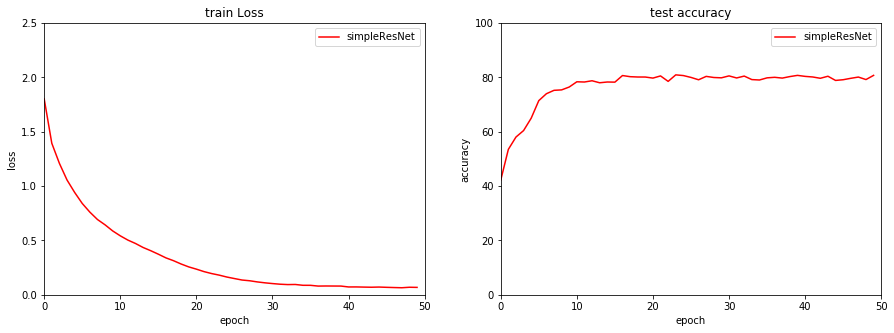

In [0]:
# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss, 'r', linestyle='-', label='simpleResNet')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,2.5)
pl.set_xlim(0,50)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy, 'r', linestyle='-', label='simpleResNet')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,50)
pl.legend()


plt.show()

# Adversarial example(Images)

In [0]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

eps=[torch.tensor([0/256]), torch.tensor([2/256]), torch.tensor([4/256]), torch.tensor([8/256]), torch.tensor([16/256])]
eps2=[0, 2, 4, 8, 16]

In [0]:
print("FGSM Example")
for e in eps:
    if e==torch.tensor([0/256]):
        prev=FGSM(clean_model, CRITERION ,images[0:1].to("cuda"), labels[0:1].to("cuda"), epsilon=e, train= False).to("cpu")
        continue
    else:
        x=FGSM(clean_model, CRITERION ,images[0:1].to("cuda"), labels[0:1].to("cuda"), epsilon=e, train= False).to("cpu")
        prev=torch.cat([prev, x])

FGSM Example


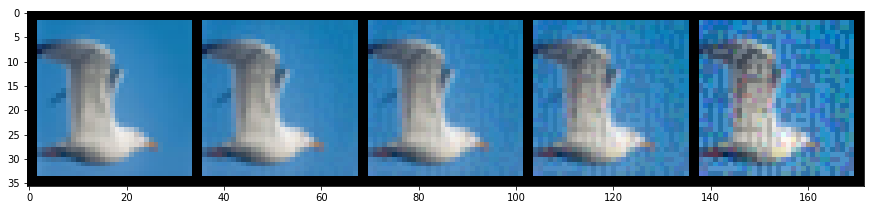

In [0]:
imshow(torchvision.utils.make_grid(prev, normalize=True))

In [0]:
print("step 1.1 Example")
for e in eps:
    if e==torch.tensor([0/256]):
        prev1=one_step_target(clean_model, CRITERION ,images[0:1].to("cuda") , epsilon=e, train= False).to("cpu")
        continue
    else:
        x=one_step_target(clean_model, CRITERION ,images[0:1].to("cuda") , epsilon=e, train= False).to("cpu")
        prev1=torch.cat([prev1, x])

step 1.1 Example


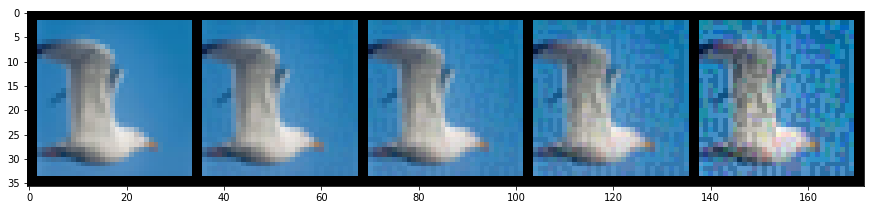

In [0]:
imshow(torchvision.utils.make_grid(prev1, normalize=True))

In [0]:
for e in eps2:
    if e==torch.tensor([0/256]):
        prev2=iterative_least_likely_class(clean_model, CRITERION ,images[0:1].to("cuda") , scale=1 , alpha=1, eps=e, train=False).to("cpu")
        continue
    else:
        x=iterative_least_likely_class(clean_model, CRITERION ,images[0:1].to("cuda") , scale=1 , alpha=1, eps=e, train=False).to("cpu")
        prev2=torch.cat([prev2, x])

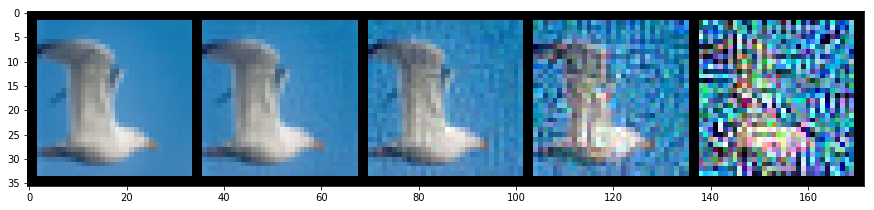

In [0]:
imshow(torchvision.utils.make_grid(prev2, normalize=True))

In [0]:
for e in eps2:
    if e==torch.tensor([0/256]):
        prev3= basic_iterative(clean_model, CRITERION ,images[0:1].to("cuda"), labels[0:1].to("cuda"),  scale=1 , alpha=1, eps=e, train=False).to("cpu")
        continue
    else:
        x= basic_iterative(clean_model, CRITERION ,images[0:1].to("cuda"), labels[0:1].to("cuda"), scale=1 , alpha=1, eps=e, train=False).to("cpu")
        prev3=torch.cat([prev3, x])

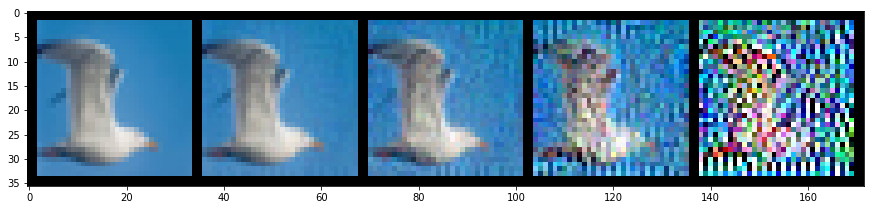

In [0]:
imshow(torchvision.utils.make_grid(prev3, normalize=True))

In [0]:
#stepl.l with SimpleResNet(in test time, we use epslion=2 )
step1= SimpleResNet().cuda()
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss1.append(fit(step1, train_loader, adv=True, clean= clean_model))
    test_accuracy1.append(eval(step1, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=clean_model))

100%|██████████| 50/50 [18:08<00:00, 21.80s/it]


In [0]:
#FGSM with SimpleResNet
FGSM_model= SimpleResNet().cuda()
train_loss2 = []
test_accuracy2 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss2.append(fit(FGSM_model, train_loader, adv=True, clean= clean_model, ll=False))
    test_accuracy2.append(eval(FGSM_model, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=clean_model, ll=False))

100%|██████████| 50/50 [16:09<00:00, 19.36s/it]


In [0]:
#baseline with SimpleResNet
baseline= SimpleResNet().cuda()
train_loss3 = []
test_accuracy3 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss3.append(fit(baseline, train_loader, adv=False))
    test_accuracy3.append(eval(baseline, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=clean_model))

100%|██████████| 50/50 [12:07<00:00, 14.60s/it]


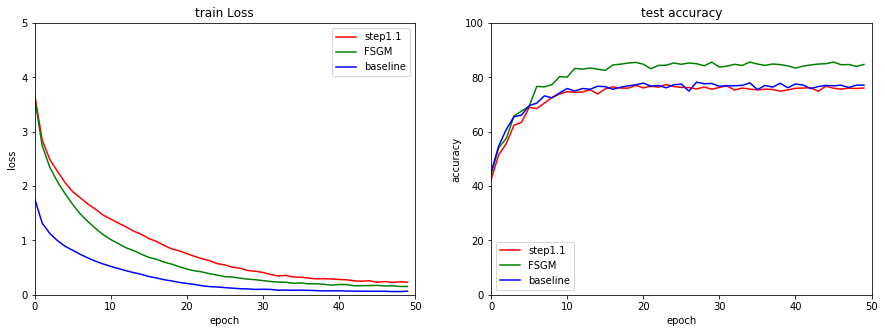

In [0]:
# Plotting the training loss and test accuracy when eps=2 (with small noise)
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss1, 'r', linestyle='-', label='step1.1')
pl.plot(train_loss2, 'g', linestyle='-', label='FSGM')
pl.plot(train_loss3, 'b', linestyle='-', label='baseline')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,5)
pl.set_xlim(0,50)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy1, 'r', linestyle='-', label='step1.1')
pl.plot(test_accuracy2, 'g', linestyle='-', label='FSGM')
pl.plot(test_accuracy3, 'b', linestyle='-', label='baseline')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,50)
pl.legend()


plt.show()

In [0]:
eps=[torch.tensor([0/256]),torch.tensor([2/256]), torch.tensor([4/256]), torch.tensor([8/256]), torch.tensor([16/256])]
adv_accuracy=[]
FSGM_accuracy=[]
base_accuracy=[]
for e in eps:
    adv_accuracy.append(eval(step1, test_loader, epsilon=e, adv=True, clean=clean_model))
    FSGM_accuracy.append(eval(FGSM_model, test_loader, epsilon=e, adv=True, clean=clean_model))
    base_accuracy.append(eval(baseline, test_loader, epsilon=e, adv=True, clean=clean_model))

NameError: ignored

In [0]:
#compare adv.training(Step l.l) and baseline
index=['clean','2', '4', '8', '16']
result={'step1.1': adv_accuracy, 'baseline': base_accuracy
}
result=DataFrame(result, index=index)
result.T

,clean,2,4,8,16
step1.1,76.78,76.09,75.25,73.09,68.07
baseline,80.41,77.12,71.62,56.48,33.62


In [0]:
index=['clean','2', '4', '8', '16']
result5={"FSGM": FSGM_accuracy,'step1.1': adv_accuracy
}
result5=DataFrame(result5, index=index)
result5.T

,clean,2,4,8,16
FSGM,80.46,77.71,74.55,66.60,51.60
step1.1,76.78,76.09,75.25,73.09,68.07


# more deeper

In [0]:
class DeepResNet(nn.Module):
    def __init__(self):
        super(DeepResNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.act1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.shortcut1 = nn.Sequential(self.conv2_2, self.act2_2, self.conv2_3)
        
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.shortcut2 = nn.Sequential(self.conv3_2, self.act3_2, self.conv3_3)
        
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2)
        
        #add addtional layers
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.shortcut3 = nn.Sequential(self.conv4_2, self.act4_2, self.conv4_3)
        
        self.act4_3 = nn.ReLU()
        self.pool4 = nn.AvgPool2d(4)
        
        
        
        
        # Output layer
        self.out = nn.Linear(256*1*1, 10)
    
    def forward(self, x):
        x=self.act1_1(self.conv1_1(x))
        x=self.act1_2(self.conv1_2(x))
        x=self.pool1(x)
        
        x=self.act2_1(self.conv2_1(x))
        x=self.act2_3(x+self.shortcut1(x))
        x=self.pool2(x)
        
        x=self.act3_1(self.conv3_1(x))
        x=self.act3_3(x+self.shortcut2(x))
        x=self.pool3(x)
        
        x=self.act4_1(self.conv4_1(x))
        x=self.act4_3(x+self.shortcut3(x))
        x=self.pool4(x)
        x = x.view(-1, 256*1*1)

        out = self.out(x)
        return out

In [0]:
#clean model2
clean_model2=DeepResNet().cuda()
train_loss4 = []
test_accuracy4 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss4.append(fit(clean_model2, train_loader, adv=False, clean= clean_model))
    test_accuracy4.append(eval(clean_model2, test_loader, epsilon=torch.tensor([0/256]), adv=False))

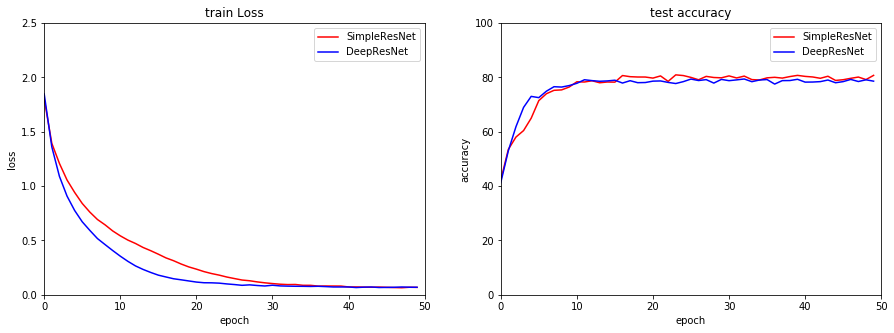

In [0]:
# Plotting the training loss and test accuracy
# This plot show deeper net is more perform than simple Network
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss, 'r', linestyle='-', label='SimpleResNet')
pl.plot(train_loss4, 'b', linestyle='-', label='DeepResNet')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,2.5)
pl.set_xlim(0,50)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy, 'r', linestyle='-', label='SimpleResNet')
pl.plot(test_accuracy4, 'b', linestyle='-', label='DeepResNet')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,50)
pl.legend()


plt.show()

In [0]:
#step1.1 with Deep network
deep_step1=DeepResNet().cuda()
train_loss5 = []
test_accuracy5 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss5.append(fit(deep_step1, train_loader, adv=True, clean= clean_model2))
    test_accuracy5.append(eval(deep_step1, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=clean_model2))

In [0]:
#baseline with Deep network
deep_baseline=DeepResNet().cuda()
train_loss6 = []
test_accuracy6 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss6.append(fit(deep_baseline, train_loader, adv=False, clean= clean_model2))
    test_accuracy6.append(eval(deep_baseline, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=clean_model2))

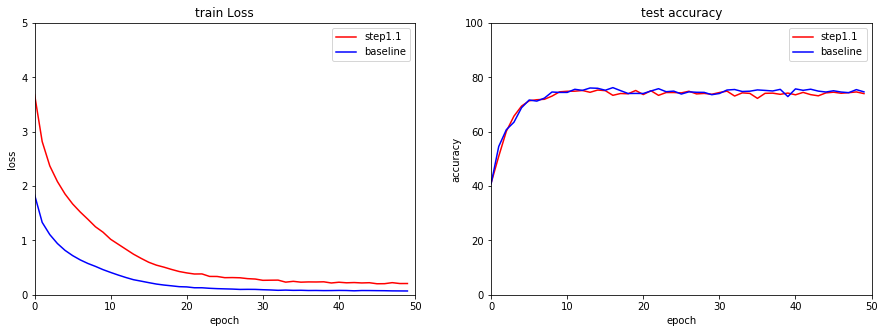

In [0]:
# Plotting the training loss and test accuracy when eps=2 
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss5, 'r', linestyle='-', label='step1.1')
pl.plot(train_loss6, 'b', linestyle='-', label='baseline')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,5)
pl.set_xlim(0,50)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy5, 'r', linestyle='-', label='step1.1')
pl.plot(test_accuracy6, 'b', linestyle='-', label='baseline')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,50)
pl.legend()


plt.show()

In [0]:
adv_accuracy1=[]
base_accuracy1=[]
for e in eps:
    adv_accuracy1.append(eval(deep_step1, test_loader, epsilon=e, adv=True, clean=clean_model2))
    base_accuracy1.append(eval(deep_baseline, test_loader, epsilon=e, adv=True, clean=clean_model2))

In [0]:
result1={'step1.1': adv_accuracy1, 'baseline': base_accuracy1
}
result1=DataFrame(result1, index=index)
result1.T

,clean,2,4,8,16
step1.1,74.54,74.02,73.08,71.51,67.14
baseline,77.93,74.66,70.44,57.08,33.89


In [0]:
#this result corresponds to table1 of the paper
index=['clean','2', '4', '8', '16']
total_result = {'Baseline, (standard training)': base_accuracy, 'Adv.training': adv_accuracy,
               'Deeper model, (standard training)': base_accuracy1, 'Deeper model, (Adv.training)': adv_accuracy1}
result_result = DataFrame(total_result, index=index)
result_result.T

,clean,2,4,8,16
"Baseline, (standard training)",80.01,77.10,70.88,53.85,30.17
Adv.training,75.95,75.24,74.37,72.68,66.88
"Deeper model, (standard training)",78.76,76.81,72.93,63.15,42.62
"Deeper model, (Adv.training)",74.73,74.59,73.99,72.25,68.16


# iterative least likely class method

In [0]:
#iterative least likely class method
adv=SimpleResNet().cuda()
train_loss7 = []
test_accuracy7 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss7.append(fit(adv, train_loader, adv=True, clean= clean_model, iter=True))
    test_accuracy7.append(eval(adv, test_loader, epsilon=2, adv=True, clean=clean_model, iter=True))

100%|██████████| 50/50 [48:02<00:00, 58.80s/it]


In [0]:
#baseline
baseline1=SimpleResNet().cuda()
train_loss8 = []
test_accuracy8 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss8.append(fit(baseline1, train_loader, adv=False))
    test_accuracy8.append(eval(baseline1, test_loader, epsilon=2, adv=True, clean=clean_model, iter=True))

100%|██████████| 50/50 [14:21<00:00, 17.23s/it]


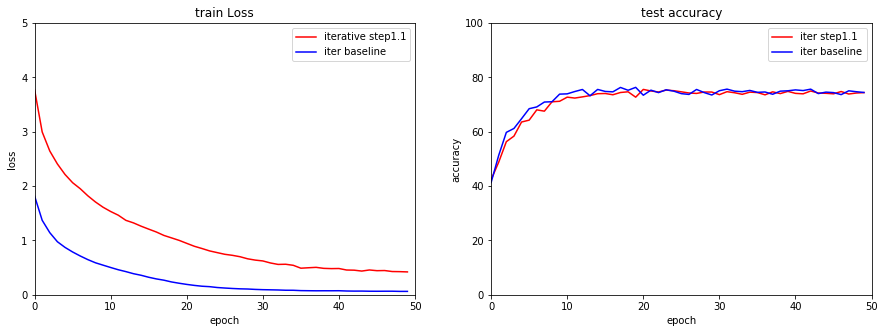

In [0]:
# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss7, 'r', linestyle='-', label='iterative step1.1')
pl.plot(train_loss8, 'b', linestyle='-', label='iter baseline')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,5)
pl.set_xlim(0,50)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy7, 'r', linestyle='-', label='iter step1.1')
pl.plot(test_accuracy8, 'b', linestyle='-', label='iter baseline')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,50)
pl.legend()


plt.show()

In [0]:
adv_accuracy3=[]
base_accuracy3=[]
for e in eps2:
    adv_accuracy3.append(eval(adv, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True))
    base_accuracy3.append(eval(baseline1, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True))

In [0]:
index=['clean','2', '4', '8', '16']
result3={'iter_one_step': adv_accuracy3, 'iter_baseline': base_accuracy3
}
result3=DataFrame(result3, index=index)
result3.T

,clean,2,4,8,16
iter_one_step,75.13,74.39,73.45,69.61,56.00
iter_baseline,80.25,74.44,53.10,20.97,9.05


In [0]:
#adv trianing with basic iterative method
adv1=SimpleResNet().cuda()
train_loss9 = []
test_accuracy9 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss9.append(fit(adv1, train_loader, adv=True, clean= clean_model, iter=True, ll=False))
    test_accuracy9.append(eval(adv1, test_loader, epsilon=2, adv=True, clean=clean_model, iter=True, ll=False))

100%|██████████| 50/50 [48:17<00:00, 57.03s/it]


In [0]:
#baseline with basic iterative method
baseline2=SimpleResNet().cuda()
train_loss10 = []
test_accuracy10 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss10.append(fit(baseline2, train_loader, adv=False))
    test_accuracy10.append(eval(baseline2, test_loader, epsilon=2, adv=True, clean=clean_model, iter=True, ll=False))

100%|██████████| 50/50 [14:20<00:00, 17.25s/it]


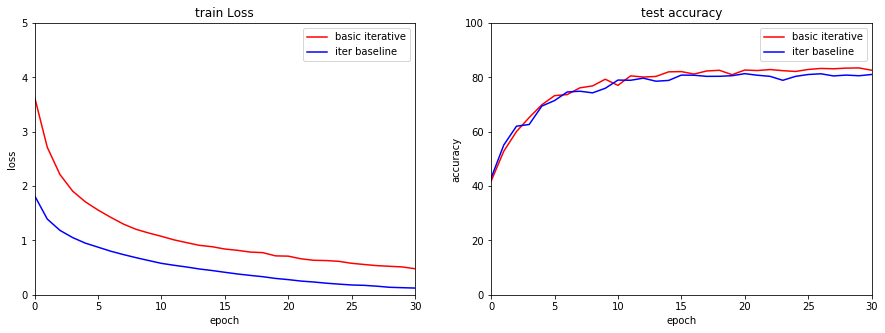

In [0]:
# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)
pl.plot(train_loss9, 'r', linestyle='-', label='basic iterative')
pl.plot(train_loss10, 'b', linestyle='-', label='iter baseline')
pl.set_title('train Loss')
pl.set_xlabel('epoch')
pl.set_ylabel("loss")
pl.set_ylim(0,5)
pl.set_xlim(0,30)
pl.legend()

pl =plt.subplot(122)
pl.plot(test_accuracy9, 'r', linestyle='-', label='basic iterative')
pl.plot(test_accuracy10, 'b', linestyle='-', label='iter baseline')
pl.set_title('test accuracy')
pl.set_xlabel('epoch')
pl.set_ylabel("accuracy")
pl.set_ylim(0,100)
pl.set_xlim(0,30)
pl.legend()


plt.show()

In [0]:
adv_accuracy4=[]
base_accuracy4=[]
for e in eps2:
    adv_accuracy4.append(eval(adv1, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True, ll=False))
    base_accuracy4.append(eval(baseline2, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True, ll=False))

In [0]:
index=['clean','2', '4', '8', '16']
result4={'iter_one_step': adv_accuracy4, 'iter_baseline': base_accuracy4
}
result4=DataFrame(result4, index=index)
result4.T

,clean,2,4,8,16
iter_one_step,81.19,83.15,82.21,79.34,69.14
iter_baseline,79.48,80.99,78.68,73.48,59.12


In [0]:
#this result corresponds to table2 of the paper
result_total2={'iter_l.l, Adv.training': adv_accuracy3, 'iter_l.l, Baseline': base_accuracy3,
         'iter_basic, Adv.training': adv_accuracy4, 'iter_basic, Baseline': base_accuracy4,}
result_total2=DataFrame(result_total2, index=index)
result_total2.T

,clean,2,4,8,16
"iter_l.l, Adv.training",75.13,74.39,73.45,69.61,56.00
"iter_l.l, Baseline",80.25,74.44,53.10,20.97,9.05
"iter_basic, Adv.training",81.19,83.15,82.21,79.34,69.14
"iter_basic, Baseline",79.48,80.99,78.68,73.48,59.12


# label leaking

In [0]:
class narrowResNet(nn.Module): # when ρ=0.5, reduce the number of channels by half
    def __init__(self):
        super(narrowResNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.act1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.shortcut1 = nn.Sequential(self.conv2_2, self.act2_2, self.conv2_3)
        
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.shortcut2 = nn.Sequential(self.conv3_2, self.act3_2, self.conv3_3)
        
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(8)
        
        # Output layer
        self.out = nn.Linear(64*1*1, 10)
    
    def forward(self, x):
        x=self.act1_1(self.conv1_1(x))
        x=self.act1_2(self.conv1_2(x))
        x=self.pool1(x)
        
        x=self.act2_1(self.conv2_1(x))
        x=self.act2_3(x+self.shortcut1(x))
        x=self.pool2(x)
        
        x=self.act3_1(self.conv3_1(x))
        x=self.act3_3(x+self.shortcut2(x))
        x=self.pool3(x)
        x = x.view(-1, 64*1*1)

        out = self.out(x)
        return out

In [0]:
class fatResNet(nn.Module):  # when ρ=2, double the number of channels 
    def __init__(self):
        super(fatResNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.act1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.shortcut1 = nn.Sequential(self.conv2_2, self.act2_2, self.conv2_3)
        
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.shortcut2 = nn.Sequential(self.conv3_2, self.act3_2, self.conv3_3)
        
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(8)
        
        # Output layer
        self.out = nn.Linear(256*1*1, 10)
    
    def forward(self, x):
        x=self.act1_1(self.conv1_1(x))
        x=self.act1_2(self.conv1_2(x))
        x=self.pool1(x)
        
        x=self.act2_1(self.conv2_1(x))
        x=self.act2_3(x+self.shortcut1(x))
        x=self.pool2(x)
        
        x=self.act3_1(self.conv3_1(x))
        x=self.act3_3(x+self.shortcut2(x))
        x=self.pool3(x)
        x = x.view(-1, 256*1*1)

        out = self.out(x)
        return out

In [0]:
eps=[torch.tensor([2/256]), torch.tensor([4/256]), torch.tensor([8/256]), torch.tensor([16/256])]
eps2=[2, 4, 8, 16]

In [0]:
narrow_adv_ratio0=[]
narrow_base_ratio0=[]
for e in eps:
    tmp1 = eval(baseline, test_loader, epsilon=e, adv=True, clean=clean_model)
    tmp2 = eval(baseline, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_base_ratio0.append(tmp1/tmp2)
    
    tmp1 = eval(step1, test_loader, epsilon=e, adv=True, clean=clean_model)
    tmp2 = eval(step1, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_adv_ratio0.append(tmp1/tmp2)

In [0]:
# narrow - clean
narrowClean=narrowResNet().cuda()
test_acc =  []
for epoch in tqdm(range(NUM_EPOCH)):
    fit(narrowClean, train_loader, adv=False)
    test_acc.append(eval(narrowClean, test_loader, epsilon=torch.tensor([2/256]), adv=False))

100%|██████████| 50/50 [07:57<00:00,  9.46s/it]


In [0]:
# baseline - narrow - step l.l
narrow_base = narrowResNet().cuda()
train_loss11 = []
test_accuracy11 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss11.append(fit(narrow_base, train_loader, adv=False))
    test_accuracy11.append(eval(narrow_base, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=narrowClean))

100%|██████████| 50/50 [08:58<00:00, 10.73s/it]


In [0]:
# adv.training - narrow - step l.l
narrow_adv= narrowResNet().cuda()
train_loss12 = []
test_accuracy12 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss12.append(fit(narrow_adv, train_loader, adv=True, clean= narrowClean))
    test_accuracy12.append(eval(narrow_adv, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=narrowClean))

100%|██████████| 50/50 [12:10<00:00, 14.56s/it]


In [0]:
narrow_adv_ratio1=[]
narrow_base_ratio1=[]
for e in eps:
    tmp1 = eval(narrow_base, test_loader, epsilon=e, adv=True, clean=narrowClean)
    tmp2 = eval(narrow_base, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_base_ratio1.append(tmp1/tmp2)
    
    tmp1 = eval(narrow_adv, test_loader, epsilon=e, adv=True, clean=narrowClean)
    tmp2 = eval(narrow_adv, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_adv_ratio1.append(tmp1/tmp2)

In [0]:
# fat - clean
fatClean= fatResNet().cuda()
test_acc =  []
for epoch in tqdm(range(NUM_EPOCH)):
    fit(fatClean, train_loader, adv=False)
    test_acc.append(eval(fatClean, test_loader, epsilon=torch.tensor([2/256]), adv=False))

100%|██████████| 50/50 [22:03<00:00, 26.44s/it]


In [0]:
# baseline - fat - step l.l
fat_base= fatResNet().cuda()
train_loss13 = []
test_accuracy13 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss13.append(fit(fat_base, train_loader, adv=False))
    test_accuracy13.append(eval(fat_base, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=fatClean))

100%|██████████| 50/50 [26:59<00:00, 32.42s/it]


In [0]:
# adv.training - fat - step l.l
fat_adv= fatResNet().cuda()
train_loss14 = []
test_accuracy14 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss14.append(fit(fat_adv, train_loader, adv=True, clean= fatClean))
    test_accuracy14.append(eval(fat_adv, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=fatClean))

100%|██████████| 50/50 [42:20<00:00, 50.83s/it]


In [0]:
narrow_adv_ratio2=[]
narrow_base_ratio2=[]
for e in eps:
    tmp1 = eval(fat_base, test_loader, epsilon=e, adv=True, clean=fatClean)
    tmp2 = eval(fat_base, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_base_ratio2.append(tmp1/tmp2)
    
    tmp1 = eval(fat_adv, test_loader, epsilon=e, adv=True, clean=fatClean)
    tmp2 = eval(fat_adv, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_adv_ratio2.append(tmp1/tmp2)

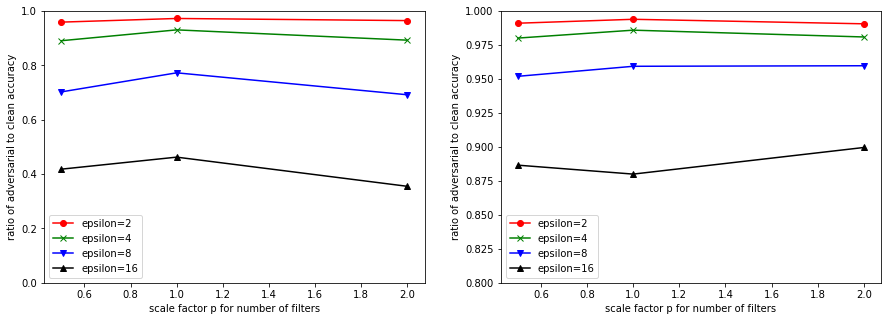

In [0]:
#copare no adversarial training, “step l.l.” adv. examples and  With adversarial training, “step l.l.” adv. examples
ratio1 = np.column_stack([narrow_base_ratio0 ,narrow_base_ratio1,narrow_base_ratio2])
ratio2 = np.column_stack([narrow_adv_ratio0 ,narrow_adv_ratio1,narrow_adv_ratio2])

# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)

pl.plot(np.array([0.5,1.0,2.0]), ratio1[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio1[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio1[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio1[3,],c='black',marker='^', label = 'epsilon=16')

# pl.set_title('train Loss')
pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0,1)
# pl.set_xlim(0,15)
pl.legend()

pl =plt.subplot(122)
pl.plot(np.array([0.5,1.0,2.0]), ratio2[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio2[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio2[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio2[3,],c='black',marker='^', label = 'epsilon=16')

pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0.8,1)

# pl.set_title('test accuracy')
# pl.set_xlabel('epoch')
# pl.set_ylabel("accuracy")
# pl.set_ylim(0,100)
# pl.set_xlim(0,15)
pl.legend()


plt.show()

In [0]:
narrow_adv_ratio3=[]
narrow_base_ratio3=[]
for e in eps2:
    tmp1 = eval(baseline, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True)
    tmp2 = eval(baseline, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_base_ratio3.append(tmp1/tmp2)
    
    tmp1 = eval(step1, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True)
    tmp2 = eval(step1, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_adv_ratio3.append(tmp1/tmp2)

In [0]:
# baseline - narrow - iter l.l
narrow_base1 = narrowResNet().cuda()
train_loss15 = []
test_accuracy15 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss15.append(fit(narrow_base1, train_loader, adv=False))
    test_accuracy15.append(eval(narrow_base1, test_loader, epsilon=2, adv=True, clean=narrowClean, iter=True))

100%|██████████| 50/50 [10:08<00:00, 12.10s/it]


In [0]:
# adv.training - narrow - iter l.l
narrow_adv1= narrowResNet().cuda()
train_loss16 = []
test_accuracy16 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss16.append(fit(narrow_adv1, train_loader, adv=True, clean= narrowClean))
    test_accuracy16.append(eval(narrow_adv1, test_loader, epsilon=2, adv=True, clean=narrowClean, iter=True))

100%|██████████| 50/50 [13:17<00:00, 15.98s/it]


In [0]:
narrow_adv_ratio4=[]
narrow_base_ratio4=[]
for e in eps2:
    tmp1 = eval(narrow_base1, test_loader, epsilon=e, adv=True, clean=narrowClean, iter=True)
    tmp2 = eval(narrow_base1, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_base_ratio4.append(tmp1/tmp2)
    
    tmp1 = eval(narrow_adv1, test_loader, epsilon=e, adv=True, clean=narrowClean, iter=True)
    tmp2 = eval(narrow_adv1, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_adv_ratio4.append(tmp1/tmp2)

In [0]:
# baseline - fat - iter l.l
fat_base1 = fatResNet().cuda()
train_loss17 = []
test_accuracy17 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss17.append(fit(fat_base1, train_loader, adv=False))
    test_accuracy17.append(eval(fat_base1, test_loader, epsilon=2, adv=True, clean=fatClean, iter=True))

100%|██████████| 50/50 [30:47<00:00, 36.97s/it]


In [0]:
# adv.training - narrow - iter l.l
fat_adv1= fatResNet().cuda()
train_loss18 = []
test_accuracy18 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss18.append(fit(fat_adv1, train_loader, adv=True, clean= narrowClean))
    test_accuracy18.append(eval(fat_adv1, test_loader, epsilon=2, adv=True, clean=fatClean, iter=True))

100%|██████████| 50/50 [35:34<00:00, 42.66s/it]


In [0]:
narrow_adv_ratio5=[]
narrow_base_ratio5=[]
for e in eps2:
    tmp1 = eval(fat_base1, test_loader, epsilon=e, adv=True, clean=fatClean, iter=True)
    tmp2 = eval(fat_base1, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_base_ratio5.append(tmp1/tmp2)
    
    tmp1 = eval(fat_adv1, test_loader, epsilon=e, adv=True, clean=fatClean, iter=True)
    tmp2 = eval(fat_adv1, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_adv_ratio5.append(tmp1/tmp2)

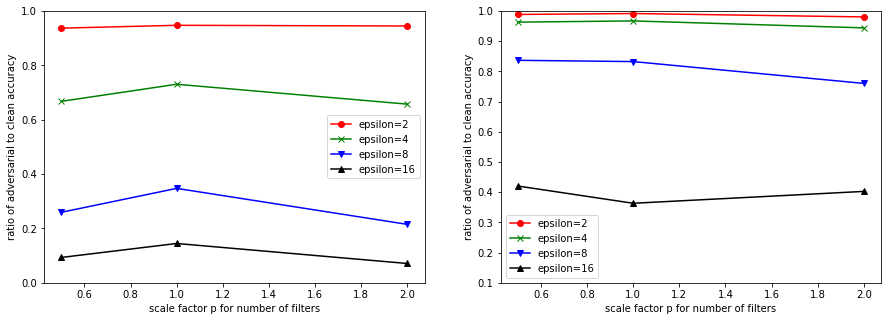

In [0]:
#compare No adversarial training, “iter. l.l.” adv. examples and  With adversarial training, “iter. l.l.” adv. examples
ratio3 = np.column_stack([narrow_base_ratio3 ,narrow_base_ratio4, narrow_base_ratio5])
ratio4 = np.column_stack([narrow_adv_ratio3 ,narrow_adv_ratio4, narrow_adv_ratio5])

# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)

pl.plot(np.array([0.5,1.0,2.0]), ratio3[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio3[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio3[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio3[3,],c='black',marker='^', label = 'epsilon=16')

# pl.set_title('train Loss')
pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0,1)
# pl.set_xlim(0,15)
pl.legend()

pl =plt.subplot(122)
pl.plot(np.array([0.5,1.0,2.0]), ratio4[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio4[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio4[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio4[3,],c='black',marker='^', label = 'epsilon=16')

pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0.1,1)

# pl.set_title('test accuracy')
# pl.set_xlabel('epoch')
# pl.set_ylabel("accuracy")
# pl.set_ylim(0,100)
# pl.set_xlim(0,15)
pl.legend()


plt.show()

In [0]:
narrow_adv_ratio6=[]
narrow_base_ratio6=[]
for e in eps2:
    tmp1 = eval(baseline, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True, ll=False)
    tmp2 = eval(baseline, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_base_ratio6.append(tmp1/tmp2)
    
    tmp1 = eval(step1, test_loader, epsilon=e, adv=True, clean=clean_model, iter=True, ll=False)
    tmp2 = eval(step1, test_loader, epsilon=e, adv=False, clean=clean_model)
    narrow_adv_ratio6.append(tmp1/tmp2)

In [0]:
# baseline - narrow - basic iter
narrow_base2 = narrowResNet().cuda()
train_loss19 = []
test_accuracy19 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss19.append(fit(narrow_base2, train_loader, adv=False))
    test_accuracy19.append(eval(narrow_base2, test_loader, epsilon=2, adv=True, clean=narrowClean, iter=True, ll=False))

100%|██████████| 50/50 [09:44<00:00, 11.74s/it]


In [0]:
# adv.training - narrow - basic iter
narrow_adv2= narrowResNet().cuda()
train_loss20 = []
test_accuracy20 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss20.append(fit(narrow_adv2, train_loader, adv=True, clean= narrowClean))
    test_accuracy20.append(eval(narrow_adv2, test_loader, epsilon=2, adv=True, clean=narrowClean, iter=True, ll=False))

100%|██████████| 50/50 [13:04<00:00, 15.65s/it]


In [0]:
narrow_adv_ratio7=[]
narrow_base_ratio7=[]
for e in eps2:
    tmp1 = eval(narrow_base2, test_loader, epsilon=e, adv=True, clean=narrowClean, iter=True, ll=False)
    tmp2 = eval(narrow_base2, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_base_ratio7.append(tmp1/tmp2)
    
    tmp1 = eval(narrow_adv2, test_loader, epsilon=e, adv=True, clean=narrowClean, iter=True, ll=False)
    tmp2 = eval(narrow_adv2, test_loader, epsilon=e, adv=False, clean=narrowClean)
    narrow_adv_ratio7.append(tmp1/tmp2)

In [0]:
# baseline - fat - basic iter
fat_base2 = fatResNet().cuda()
train_loss21 = []
test_accuracy21 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss21.append(fit(fat_base2, train_loader, adv=False))
    test_accuracy21.append(eval(fat_base2, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=fatClean, iter=True,  ll=False))

100%|██████████| 50/50 [22:56<00:00, 27.48s/it]


In [0]:
# adv.training - narrow - iter l.l
fat_adv2= fatResNet().cuda()
train_loss22 = []
test_accuracy22 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss22.append(fit(fat_adv2, train_loader, adv=True, clean= narrowClean))
    test_accuracy22.append(eval(fat_adv2, test_loader, epsilon=torch.tensor([2/256]), adv=True, clean=fatClean, iter=True,  ll=False))

100%|██████████| 50/50 [27:28<00:00, 32.96s/it]


In [0]:
narrow_adv_ratio8=[]
narrow_base_ratio8=[]
for e in eps2:
    tmp1 = eval(fat_base2, test_loader, epsilon=e, adv=True, clean=fatClean, iter=True,  ll=False)
    tmp2 = eval(fat_base2, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_base_ratio8.append(tmp1/tmp2)
    
    tmp1 = eval(fat_adv2, test_loader, epsilon=e, adv=True, clean=fatClean, iter=True,  ll=False)
    tmp2 = eval(fat_adv2, test_loader, epsilon=e, adv=False, clean=fatClean)
    narrow_adv_ratio8.append(tmp1/tmp2)

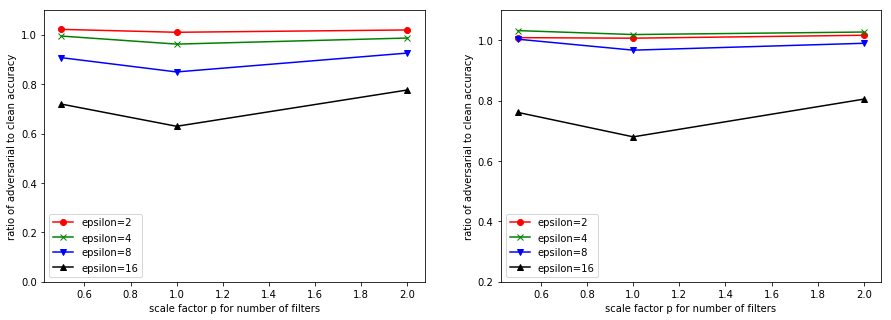

In [0]:
#compare No adversarial training, “basic iter.” adv. examples and  With adversarial training, “basic iter.” adv. examples
ratio5 = np.column_stack([narrow_base_ratio6 ,narrow_base_ratio7, narrow_base_ratio8])
ratio6 = np.column_stack([narrow_adv_ratio6 ,narrow_adv_ratio7, narrow_adv_ratio8])

# Plotting the training loss and test accuracy
fig = plt.figure(figsize=(15,5))
pl =plt.subplot(121)

pl.plot(np.array([0.5,1.0,2.0]), ratio5[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio5[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio5[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio5[3,],c='black',marker='^', label = 'epsilon=16')

# pl.set_title('train Loss')
pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0,1.1)
# pl.set_xlim(0,15)
pl.legend()

pl =plt.subplot(122)
pl.plot(np.array([0.5,1.0,2.0]), ratio6[0,],c='r',marker='o', label = 'epsilon=2')
pl.plot(np.array([0.5,1.0,2.0]), ratio6[1,],c='g',marker='x', label = 'epsilon=4')
pl.plot(np.array([0.5,1.0,2.0]), ratio6[2,],c='b',marker='v', label = 'epsilon=8')
pl.plot(np.array([0.5,1.0,2.0]), ratio6[3,],c='black',marker='^', label = 'epsilon=16')

pl.set_xlabel('scale factor p for number of filters')
pl.set_ylabel("ratio of adversarial to clean accuracy")
pl.set_ylim(0.2,1.1)

# pl.set_title('test accuracy')
# pl.set_xlabel('epoch')
# pl.set_ylabel("accuracy")
# pl.set_ylim(0,100)
# pl.set_xlim(0,15)
pl.legend()


plt.show()

In [0]:
eps=[torch.tensor([0/256]),torch.tensor([2/256]), torch.tensor([4/256]), torch.tensor([8/256]), torch.tensor([16/256])]
adv_accuracy=[]
FSGM_accuracy=[]
for e in eps:
    adv_accuracy.append(eval(step1, test_loader, epsilon=e, adv=True, clean=clean_model))
    FSGM_accuracy.append(eval(FGSM_model, test_loader, epsilon=e, adv=True, clean=clean_model, ll=False))

In [0]:
#this result corresponds to table3 of the paper
index=['clean','2', '4', '8', '16']
result5={"FSGM": FSGM_accuracy,'step1.1': adv_accuracy
}
result5=DataFrame(result5, index=index)
result5.T

,clean,2,4,8,16
FSGM,79.17,83.78,86.67,88.81,87.37
step1.1,75.54,74.78,74.38,72.67,68.44
